inspired from https://analyticsindiamag.com/my-experiment-with-unet-building-an-image-segmentation-model/ and https://www.kaggle.com/c0conuts/unet-imagedatagenerator-lb-0-336

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import time

import skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint


from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

from skimage.feature import peak_local_max

#import tensorflow as tf

def dice_coefficient(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)
  return numerator / (denominator + tf.keras.backend.epsilon())



Mounted at /content/drive


In [2]:
# Set some parameters
BATCH_SIZE = 12 # the higher the better WATCHOUT too big problem of GPU memory
IMG_WIDTH = 1440 
IMG_HEIGHT = 1920 
IMG_CHANNELS = 3
seed = 42
#CUT=2
NEW_IMG_WIDTH = 832 # for faster computing 
NEW_IMG_HEIGHT = 832 # for faster computing 

# Import data

In [3]:
code_dir='/content/drive/Shared drives/fir_cone_detector'
masks_dir=code_dir+'/data/masks_tree'
images_dir=code_dir+'/data/images'
images_list = os.listdir(images_dir)
masks_list = os.listdir(masks_dir)
print(masks_list[:5])
print(images_list[:5])
print('nb of masks=', len(masks_list), 'nb of images=', len(images_list))

['tree43_tree.ome.tiff', 'tree41_tree.ome.tiff', 'tree30_tree.ome.tiff', 'tree36_tree.ome.tiff', 'tree24_tree.ome.tiff']
['tree46.jpg', 'tree43.jpg', 'tree42.jpg', 'tree40.jpg', 'tree41.jpg']
nb of masks= 33 nb of images= 51


tree44_tree.ome.tiff
min mask= 0 max mask= 1
mask shape= (832, 832)
min img= 0 max img= 255
img shape= (832, 832, 3)


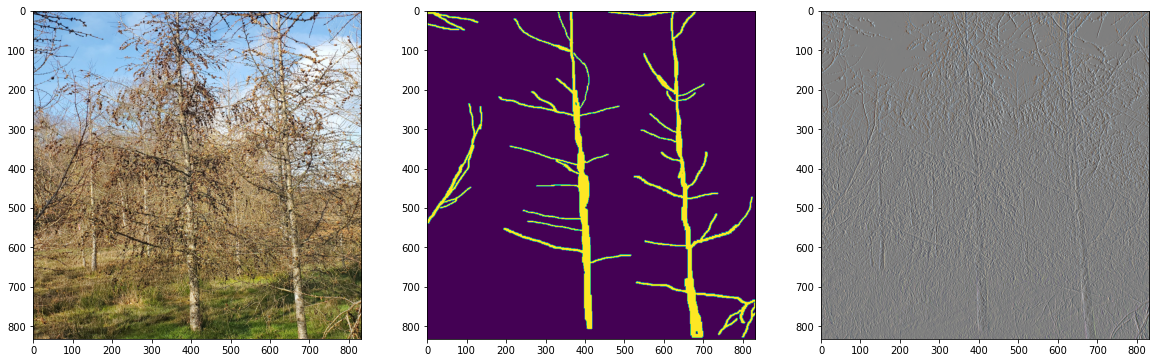

In [4]:
n=np.random.randint(len(masks_list))

# Mask
mask_name=masks_list[n]
print(mask_name)
mask_path=os.path.join(masks_dir,mask_name)
mask= imread(mask_path)[:,:]
mask = cv2.resize(mask, ( NEW_IMG_WIDTH, NEW_IMG_HEIGHT), interpolation = cv2.INTER_AREA)# mode='constant', preserve_range=True)

print('min mask=', np.min(mask), 'max mask=', np.max(mask))
print('mask shape=', np.shape(mask))


# Image
img_name=mask_name[:-14]+'.jpg'
img_path=os.path.join(images_dir,img_name)
img = imread(img_path)[:,:,:IMG_CHANNELS]
#img = img/255
img =cv2.resize(img, (NEW_IMG_WIDTH, NEW_IMG_HEIGHT), interpolation = cv2.INTER_AREA) #resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
# Sobel Edge Detection
sobel= cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3) # Sobel Edge Detection on the X axis
sobel=(sobel-np.min(sobel))/(np.max(sobel)-np.min(sobel))
print('min img=', np.min(img), 'max img=', np.max(img))
print('img shape=', np.shape(img))

fig, (ax1, ax2, ax3)=plt.subplots(1,3, figsize=(20,20))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(sobel)


# Preprocessing images (try)

In [ ]:
n=np.random.randint(len(masks_list))
img_name=images_list[n]
img_path=os.path.join(images_dir,img_name)
img = imread(img_path)[:,:,:IMG_CHANNELS]
img =cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_AREA) #resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # Hue Saturation Value
yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV) # Y (luma component) and two chrominance components, called U (blue projection) and V (red projection) 
fig, (ax1, ax2, ax3)=plt.subplots(1,3,figsize=(30,30))
ax1.imshow(img)
ax1.set_title('bgr')
ax2.imshow(hsv)
ax2.set_title('hsv:  ')
ax3.imshow(yuv)
ax3.set_title('yuv')

Create Input and Target data

In [ ]:
N=len(masks_list)
print(N)
Y= np.zeros((N,  IMG_HEIGHT,IMG_WIDTH, 1), dtype=np.bool) #np.bool)
X = np.zeros((N, IMG_HEIGHT,IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

for n in range(N):
  mask_name=masks_list[n]
  img_name=mask_name[:-14]+'.jpg'
 
  img_path=os.path.join(images_dir, img_name)
  mask_path=os.path.join(masks_dir, mask_name)
  
  img = imread(img_path)[:,:,:IMG_CHANNELS]
  img = cv2.resize(img, ( IMG_WIDTH, IMG_HEIGHT ))

  X[n] =img

  mask= imread(mask_path)[:,:]
  mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA ) #resize(mask, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
  mask=np.reshape(mask,(IMG_HEIGHT, IMG_WIDTH, 1) )
  Y[n] = np.array(mask)


16


# Prepare data

In [5]:
N=len(masks_list)
Y= np.zeros((N , NEW_IMG_HEIGHT ,NEW_IMG_WIDTH  , 1), dtype=np.bool) #np.bool)
X = np.zeros((N , NEW_IMG_HEIGHT ,NEW_IMG_WIDTH , IMG_CHANNELS), dtype=np.float32)

for n in range(N):
  mask_name=masks_list[n]
  img_name=mask_name[:-14]+'.jpg'
 
  img_path=os.path.join(images_dir, img_name)
  mask_path=os.path.join(masks_dir, mask_name)
  
  img = imread(img_path)[:,:,:IMG_CHANNELS]
  img = cv2.resize(img, ( NEW_IMG_WIDTH,  NEW_IMG_HEIGHT))
  img=np.reshape(img,(NEW_IMG_HEIGHT,NEW_IMG_WIDTH, IMG_CHANNELS) ) 
  #sobel= cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3) # Sobel Edge Detection on the X axis
  #sobel=(sobel-np.min(sobel))/(np.max(sobel)-np.min(sobel))

  mask= imread(mask_path)[:,:]
  mask = cv2.resize(mask, ( NEW_IMG_WIDTH,NEW_IMG_HEIGHT), interpolation = cv2.INTER_AREA ) #resize(mask, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
  mask=np.reshape(mask,(NEW_IMG_HEIGHT,NEW_IMG_WIDTH, 1) ) 
 
  X[n] =img
  #X[n]=sobel
  Y[n] = mask

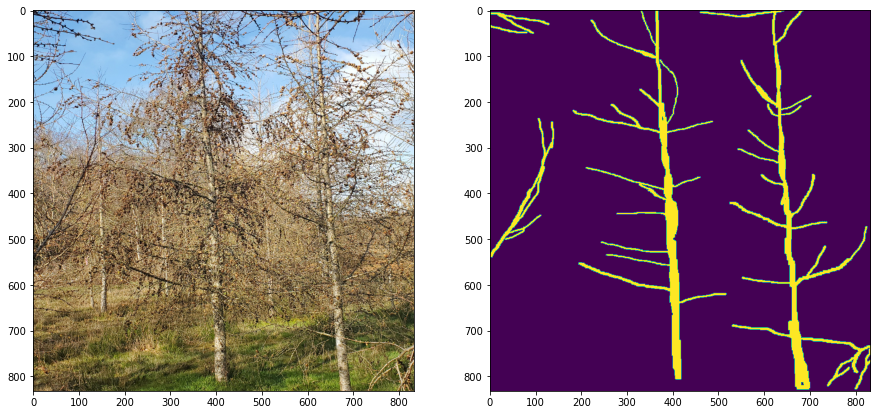

In [6]:
n=np.random.randint(len(X))
# Mask
mask=Y[n]
mask=np.reshape(mask,(NEW_IMG_HEIGHT , NEW_IMG_WIDTH) )
# Image
img=X[n]
img =np.reshape(img ,(NEW_IMG_HEIGHT , NEW_IMG_WIDTH, IMG_CHANNELS) )/255

fig, (ax1, ax2)=plt.subplots(1,2, figsize=(15,15))
ax1.imshow(img)
ax2.imshow(mask)

Data Augmentation

In [7]:
from keras.preprocessing import image
SPLIT=0.9
# Creating the training Image and Mask generator
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

# Keep the same seed for image and mask generators so they fit together
seed=42
image_datagen.fit(X[:int(X.shape[0]*SPLIT)], augment=True, seed=seed)
mask_datagen.fit(Y[:int(Y.shape[0]*SPLIT)], augment=True, seed=seed)

x=image_datagen.flow(X[:int(X.shape[0]*SPLIT)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y[:int(Y.shape[0]*SPLIT)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)


# Creating the validation Image and Mask generator
image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X[int(X.shape[0]*SPLIT):], augment=True, seed=seed)
mask_datagen_val.fit(Y[int(Y.shape[0]*SPLIT):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X[int(X.shape[0]*SPLIT):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y[int(Y.shape[0]*SPLIT):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

#print('train size=', np.shape(x),'; val size=', np.shape(x_val))
#creating a training and validation generator that generate masks and images
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

# Model

## Create

In [10]:
# Build U-Net model
#inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
inputs = Input((NEW_IMG_HEIGHT, NEW_IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s) #(s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 832, 832, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 832, 832, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 832, 832, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 832, 832, 16) 0           conv2d_11[0][0]                  
____________________________________________________________________________________________

In [8]:
inputs = Input((NEW_IMG_HEIGHT, NEW_IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs) 
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s) #same size (padding=same)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1) #divide size by 2

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 832, 832, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 832, 832, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 832, 832, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 832, 832, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

### Import Model from directory

In [ ]:
weight_path='/content/drive/Shareddrives/fir_cone_detector/models/training/unet_tree.h5'
model=keras.models.load_model(weight_path, custom_objects={'dice_coefficient': dice_coefficient})

## Train

### Train with augmentation

In [11]:
# Fit model (former perf: val loss=0.13, dice=0.34)  val_loss: 0.0764 - val_dice_coefficient: 0.4148
# big model, no sobel: val_loss: 0.0846 - val_dice_coefficient: 0.4305 / with sobel: val_loss: 0.1559 - val_dice_coefficient: 0.0420
# medium model: no sobel  val_loss: 0.1448 - val_dice_coefficient: 0.2979
# small model, no sobel: val_loss: 0.0989 - val_dice_coefficient: 0.3374
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('UNet.h5', verbose=1, save_best_only=True)
history = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=50, epochs=30, callbacks=[earlystopper, checkpointer])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
50/50 [==============================] - 90s 2s/step - loss: 0.2043 - dice_coefficient: 0.0519 - val_loss: 0.1764 - val_dice_coefficient: 0.0528

Epoch 00001: val_loss improved from inf to 0.17636, saving model to UNet.h5
Epoch 2/30
50/50 [==============================] - 86s 2s/step - loss: 0.1888 - dice_coefficient: 0.0667 - val_loss: 0.1651 - val_dice_coefficient: 0.0775

Epoch 00002: val_loss improved from 0.17636 to 0.16512, saving model to UNet.h5
Epoch 3/30
50/50 [==============================] - 89s 2s/step - loss: 0.1715 - dice_coefficient: 0.0992 - val_loss: 0.1567 - val_dice_coefficient: 0.1007

Epoch 00003: val_loss improved from 0.16512 to 0.15672, saving model to UNet.h5
Epoch 4/30
50/50 [==============================] - 88s 2s/step - loss: 0.1580 - dice_coefficient: 0.1599 - val_loss: 0.1779 - val_dice_coefficient: 0.1302

Epoch 00004: val_loss did not improve from 0.15672
Epoch 5/30
50/50 [==============================] - 88s 2s/step - loss: 0.1523 - dice

## Evaluate

Text(0.5, 0, 'epochs')

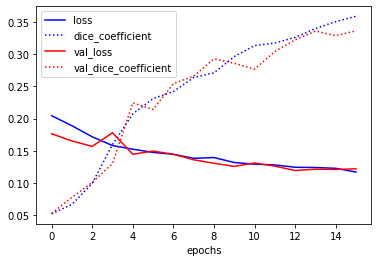

In [12]:
loss=history.history['loss']; val_loss=history.history['val_loss']
dice=history.history['dice_coefficient']; val_dice=history.history['val_dice_coefficient']

plt.plot(loss,'b-', label='loss')
plt.plot(dice,'b:', label='dice_coefficient')
plt.plot(val_loss,'r-', label='val_loss')
plt.plot(val_dice,'r:', label='val_dice_coefficient')
plt.legend()
plt.xlabel('epochs')

In [24]:
weight_path='/content/drive/Shareddrives/fir_cone_detector/models/training/unet_tree.h5'
model.save(weight_path)

## Predict

In [ ]:
weight_path='/content/drive/Shareddrives/fir_cone_detector/models/training/unet_tree.h5'
model=keras.models.load_model(weight_path, custom_objects={'dice_coefficient': dice_coefficient})

time of execution= 0.56 s


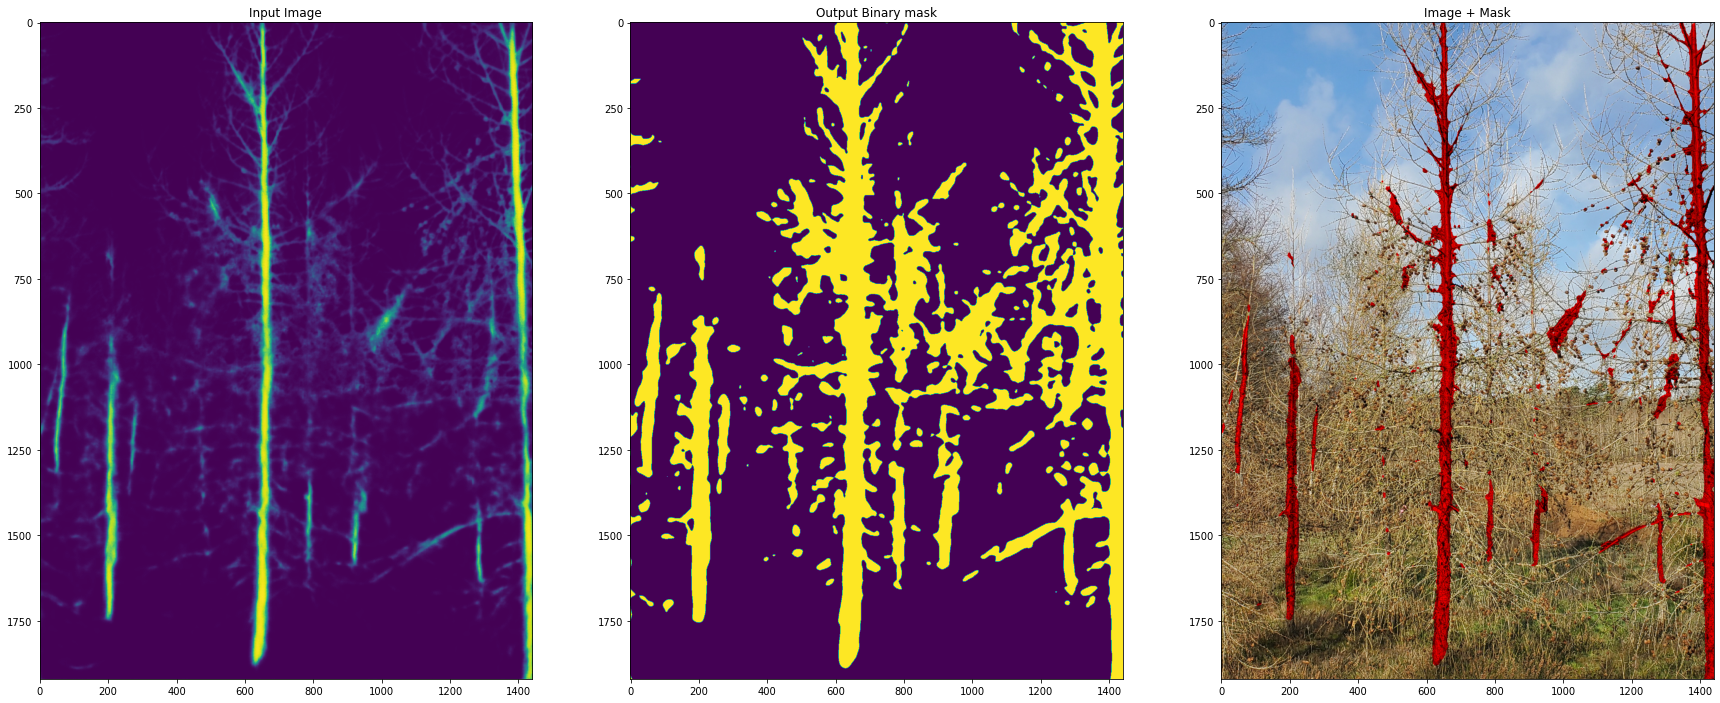

In [14]:
t0=time.perf_counter()

# pick image
n=np.random.randint(len(images_list))
img_name=images_list[n]
img_path=os.path.join(images_dir, img_name)
img = imread(img_path)[:,:,:IMG_CHANNELS]


# compute mask
im =cv2.resize(img, (NEW_IMG_WIDTH, NEW_IMG_HEIGHT), interpolation = cv2.INTER_AREA)
im = np.reshape(im,  (1, NEW_IMG_HEIGHT, NEW_IMG_WIDTH, IMG_CHANNELS) )
mask = model.predict(im)
mask=np.reshape(mask, (NEW_IMG_HEIGHT, NEW_IMG_WIDTH) )
mask =cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_AREA)
filtered_mask=skimage.filters.gaussian(mask, sigma=5)

# assemble mask+img
img_and_mask=np.copy(img)
CX, CY=np.where(mask>0.2*np.max(mask))
for cx,cy in zip(CX, CY):
  img_and_mask[cx, cy,1]=0 # mute blue
  img_and_mask[cx, cy,2]=0 # mute mute green

# plot
fig, (ax1, ax2, ax3)=plt.subplots(1,3,figsize=(30,30))
#ax1.imshow(img)
ax1.imshow(mask)
ax1.set_title('Input Image')
ax2.imshow(filtered_mask>0.05)
ax2.set_title('Output Binary mask')
ax3.imshow(img_and_mask)
ax3.set_title('Image + Mask')
t1=time.perf_counter()
print('time of execution=', round(t1-t0,2) , 's')

## Extract middle tree


In [19]:
def Bbox(img,   THR=0.07, MARGIN=100):
  h, w = np.shape(img)
  img_centroid=[h//2, w//2]
  # filter
  filtered_img=skimage.filters.gaussian(img, sigma=10)
  # label image regions
  label_im = skimage.measure.label(filtered_img > THR, background=0, connectivity=2) #skimage.measure.label(label_image, background=None, return_num=False, connectivity=None)
  regions = skimage.measure.regionprops(label_im)

  min=np.inf
  for region in regions:
    centroid=region.centroid
    distance=np.sqrt((centroid[0]-img_centroid[0])**2+(centroid[1]-img_centroid[1])**2)
    if region.area>30000 and distance<min:
      min=distance
      print(centroid)
      minr, minc, maxr, maxc=region.bbox
  # add margin and set limits
  minr= np.min( [np.max([minr-MARGIN, 0]), 400] )
  minc= np.max([minc-MARGIN, 300])
  maxr= np.max( [np.min([maxr, h]), h-400])
  maxc= np.min([maxc+MARGIN, w-300])
  return [minr, minc, maxr, maxc], label_im
 

tree13.jpg
(971.0452834701173, 719.301080006042)
time of execution= 0.66 s


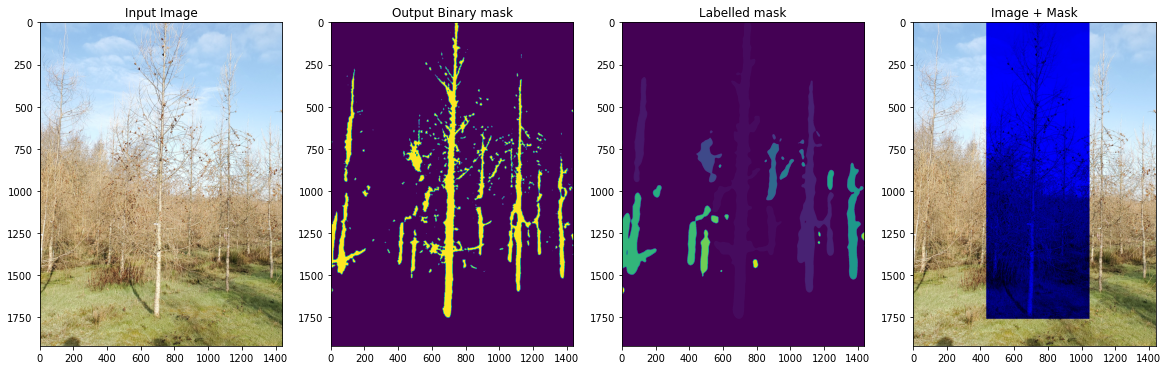

In [23]:
t0=time.perf_counter()

# pick image
n=np.random.randint(len(images_list))
img_name=images_list[n]
print(img_name)
img_path=os.path.join(images_dir, img_name)
img = imread(img_path)[:,:,:IMG_CHANNELS]


# compute mask
im =cv2.resize(img, (NEW_IMG_WIDTH, NEW_IMG_HEIGHT), interpolation = cv2.INTER_AREA)
im = np.reshape(im,  (1, NEW_IMG_HEIGHT, NEW_IMG_WIDTH, IMG_CHANNELS) )
mask = model.predict(im)
mask=np.reshape(mask, (NEW_IMG_HEIGHT, NEW_IMG_WIDTH) )
mask =cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_AREA)
[minr, minc, maxr, maxc], label_im=Bbox(mask)

img_and_bbox=np.copy(img)
img_and_bbox[minr:maxr, minc:maxc, 0:2]=np.zeros_like(img_and_bbox[minr:maxr, minc:maxc, 0:2])

# plot
fig, (ax1, ax2, ax3, ax4)=plt.subplots(1,4,figsize=(20,20))
ax1.imshow(img)
ax1.set_title('Input Image')
ax2.imshow(mask>0.1)
ax2.set_title('Output Binary mask')
ax3.imshow(label_im)
ax3.set_title('Labelled mask')
ax4.imshow(img_and_bbox)
ax4.set_title('Image + Mask')
t1=time.perf_counter()
print('time of execution=', round(t1-t0,2) , 's')